***
## **TCC** <img src="https://cdn-icons-png.flaticon.com/512/4389/4389315.png" width="5%">
***

TCC de João Paulo de Oliveira Câmara Fernandes

<p>
&emsp; A elaboração da monografia da residência em TI envolve a realização de um projeto, cujo resultado final é um produto entregável que deve ser útil e relevante para a instituição em que o residente está inserido. Para alcançar esse objetivo, é necessário um planejamento metódico e estratégico, que permita a utilização adequada de recursos e ferramentas para a concretização do projeto.</p>
<p>
&emsp; No caso da minha residência em TI no Tribunal Regional Federal da 5ª Região  (TRF5), o projeto foi pensado em conjunto com pessoas de dentro da instituição, para atender às suas necessidades e expectativas. A partir das discussões e da coleta de informações, o projeto foi aprimorado e adaptado para o contexto específico do TRF5, de modo a proporcionar uma solução prática e efetiva.
</p>

O objetivo do meu trabalho de conclusão de curso é dar sua parcela de ajuda em melhoria no setor jurídico com auxílio da inteligência artificial. 

<br>
<p align=center>
<img src="https://cdn-icons-png.flaticon.com/512/2912/2912872.png" width="30%"></p>
<br>

O trabalho consiste em classificar o texto da petição em uma das 3 classes de prioridade para encaminhar o processo para o local  correto e ter o trâmite de acordo com sua necessidade, sem precisar que o servidor perca tempo lendo as petições inciais.


Processos classificados como "Normal", é direcionado à secretaria da vara correspondente, e tem seu trâmite normal. Já os que são classificados como "Prioridade", ele passa direto para assessoria, pulando etapas em relação ao processo normal. A última classificação é a "Urgência", onde o processo também passa direto para assessoria, porém, com a necessidade de haver ato jurisdicional antes de acontecer a sentença.

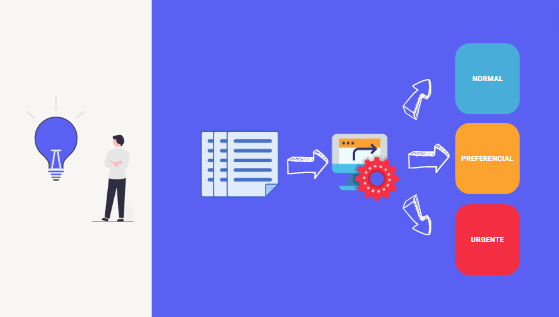

Antes de começar a execução do trabalho, é interessante mostrar o Diagrama de Fluxo do projeto, onde verificamos cada etapa realizada. 

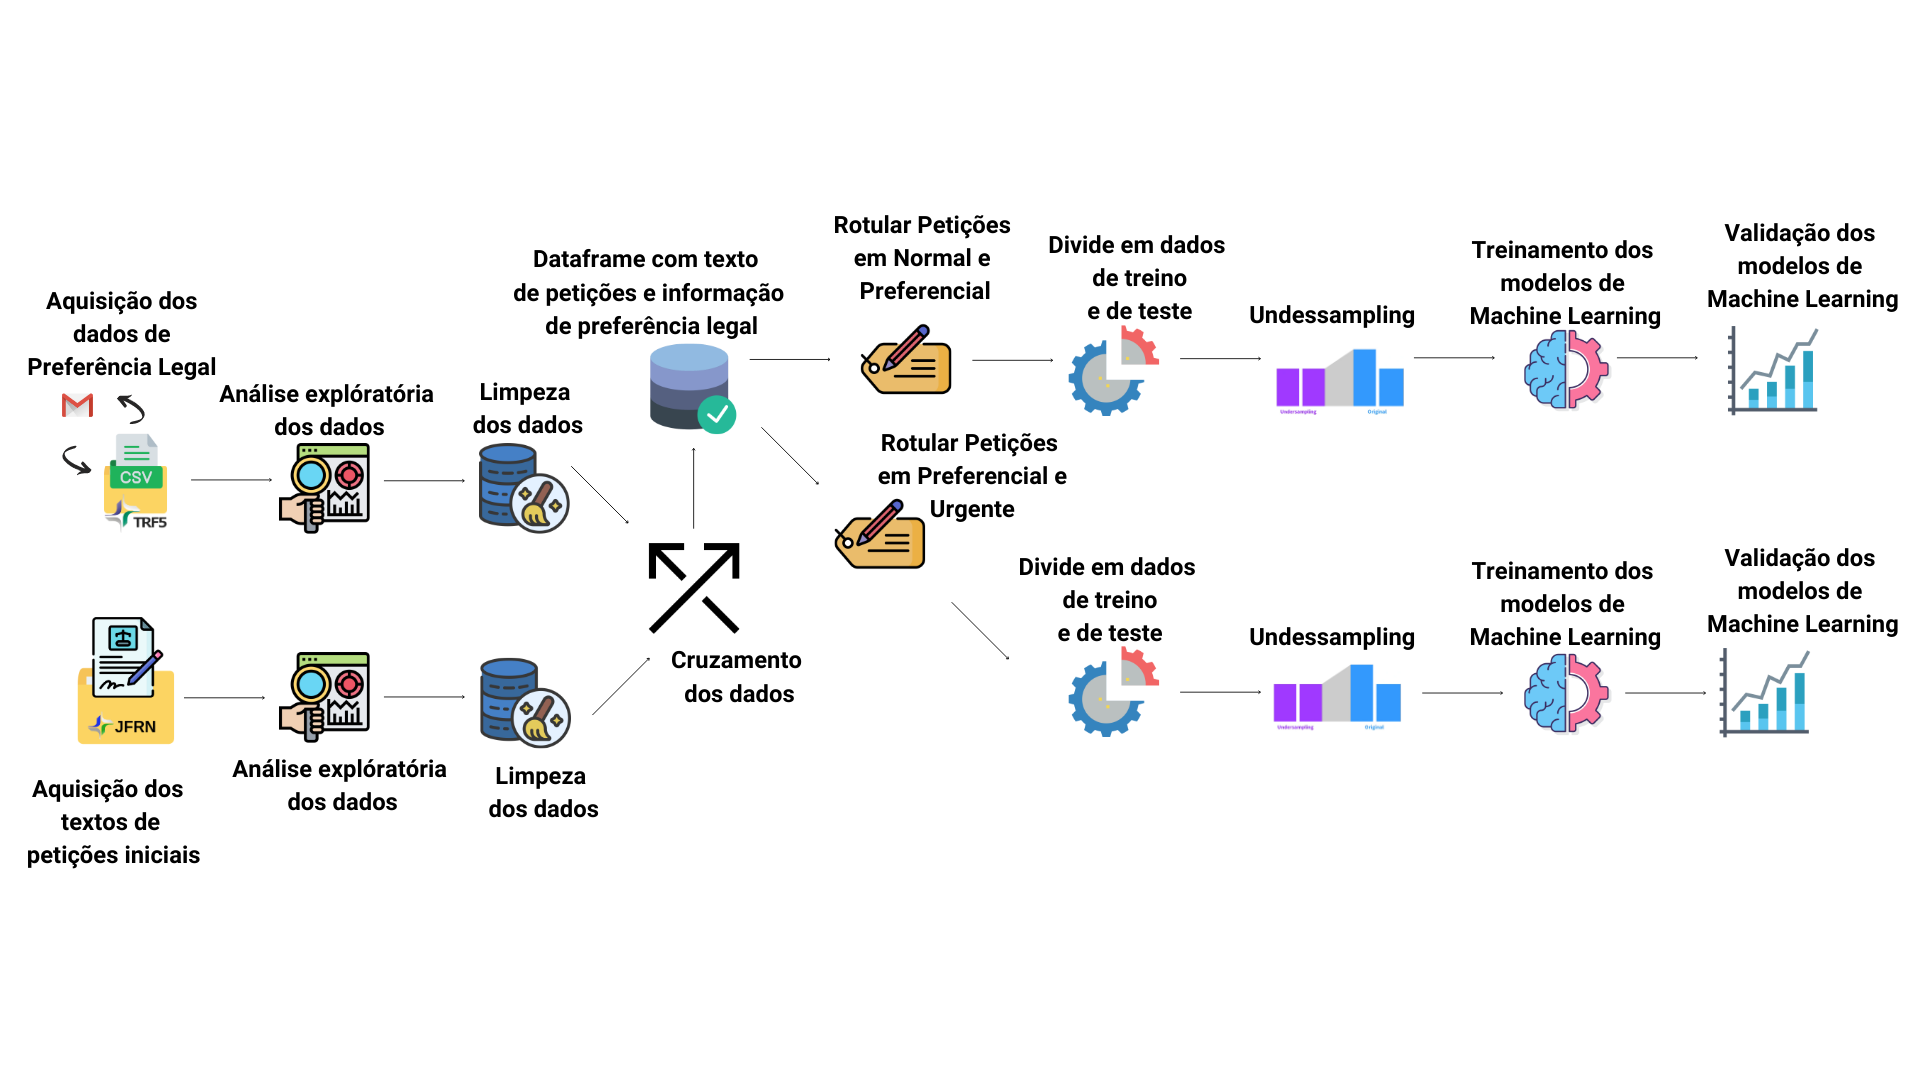

Após essa introdução inicial, podemos dar andamento na execução do trabalho.

***
## **Carregamento de dependências** <img src="https://cdn-icons-png.flaticon.com/512/4461/4461808.png" width="3%">
***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!sudo apt install build-essential libpoppler-cpp-dev pkg-config python3-dev -q

Reading package lists...
Building dependency tree...
Reading state information...
pkg-config is already the newest version (0.29.1-0ubuntu4).
python3-dev is already the newest version (3.8.2-0ubuntu2).
build-essential is already the newest version (12.8ubuntu1.1).
libpoppler-cpp-dev is already the newest version (0.86.1-0ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [4]:
!pip install pdftotext -q

In [5]:
import glob
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pdftotext
import re
import seaborn as sns
import plotly.express as px

from imblearn.under_sampling import RandomUnderSampler
from pandas.core.common import random_state
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from xgboost import XGBClassifier


# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')


In [6]:
nltk.download('all')

stopwords = nltk.corpus.stopwords.words('portuguese')

stemmer = nltk.stem.RSLPStemmer()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

***
## **Importando os documentos de petição** <img src="https://as2.ftcdn.net/v2/jpg/01/69/33/39/1000_F_169333910_pGApA6p8bYBGq0oNmJYJLOswGfCRZuxE.jpg" width="3%">
***

Foi disponibilizado uma pasta de com 62200 documentos em PDF's, utilizados em um outro trabalho de conclusão de curso, do residente Jonathan Jalles. 

Para extração dos dados, a equipe do NTIC da JFRN liberou acesso a uma base de dados de homologação do sistema de processo judicial eletrônico Creta, em um banco de dados Postgres. As petições iniciais estavam em formato binário e o residente em se trabalho transformou em PDF todos os registros disponibilizados. 

In [ ]:
# Funções que recebem a lista de arquivos e no final retorna um dataframe com 
# colunas do nome do documento e texto do documento

def transforma_dataframe(lista_arquivos):
  lista_strings = []
  for peticao in lista_arquivos:
    with open(peticao, "rb") as f:
      pdf = pdftotext.PDF(f)
    lista_strings.append("\n\n".join(pdf))


  df = cria_dataframe(lista_arquivos, lista_strings)
  return df

def cria_dataframe(lista_arquivos, lista_strings):
  dicionario_peticao = {
    'nome_documento': lista_arquivos,
    'conteudo_peticao': lista_strings,
  }
  
  df_peticao_inicial = pd.DataFrame(dicionario_peticao)
  return df_peticao_inicial

  

In [ ]:
lista_arquivos = []
for arquivo in glob.glob(r'/content/drive/MyDrive/Colab Notebooks/tcc/peticao/*pdf'):
  if arquivo not in lista_arquivos:
    lista_arquivos.append(arquivo)

arquivos_peticao = transforma_dataframe(lista_arquivos)

In [1]:
#@title
# lista_arquivos = []
# for arquivo in glob.glob(r'/content/drive/MyDrive/Colab Notebooks/tcc/pasta_teste/*pdf'):
#   if arquivo not in lista_arquivos:
#     lista_arquivos.append(arquivo)

# arquivos_peticao = transforma_dataframe(lista_arquivos)

Ao fazer uma análise inicial, foi constatado muitos documentos que não eram petições iniciais, que podem ter sido inseridos errados pelo advogado. 

Um documento aparecia constantemente era o "TERMO DE MIGRAÇÃO DE PROCESSO FÍSICO". Foi feito uma função que verificava se esse documento é um termo de migração ou não, e inclui uma feature que retorna um boolean. A finalidade disso, era trabalhar apenas com documentos que não fossem termos de migração de processo físico.

In [ ]:
def verifica_termo_migracao(texto_documento):
  regex_termo_migracao = r"(TERMO DE MIGRAÇÃO DE PROCESSO FÍSICO)"
  termo_migracao = re.search(regex_termo_migracao, texto_documento, re.IGNORECASE)

  if termo_migracao is None:
    return False  
  else:
    return True

In [ ]:
# Percorre todos os registros e aplica a função 'verifica_termo_migracao'
arquivos_peticao['Migracao Processo Fisico'] = arquivos_peticao['conteudo_peticao'].apply(verifica_termo_migracao)

In [ ]:
arquivos_peticao

,nome_documento,conteudo_peticao,Migracao Processo Fisico
0,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,TRIBUNAL REGIONAL FEDERAL DA 5ª REGIÃO\n8° VAR...,True
1,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,TRIBUNAL REGIONAL FEDERAL DA 5ª REGIÃO\n10° VA...,True
2,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,TRIBUNAL REGIONAL FEDERAL DA 5ª REGIÃO\n8° VAR...,True
3,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,TRIBUNAL REGIONAL FEDERAL DA 5ª REGIÃO\n8° VAR...,True
4,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,TRIBUNAL REGIONAL FEDERAL DA 5ª REGIÃO\n10° VA...,True
...,...,...,...
62195,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,"Petição anexa, em formato *.PDF",False
62196,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,False
62197,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,False
62198,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,PETIÇÃO INICIAL EM PDF ANEXO,False


Foi verificado que cerca de 5% dos documentos eram registros de termo de migração de processo físico, o que totaliza 3197 dos arquivos. 

In [ ]:
arquivos_peticao['Migracao Processo Fisico'].value_counts()/arquivos_peticao.shape[0]

False    0.948601
True     0.051399
Name: Migracao Processo Fisico, dtype: float64

In [ ]:
arquivos_peticao['Migracao Processo Fisico'].value_counts()

False    59003
True      3197
Name: Migracao Processo Fisico, dtype: int64

Como foram disponibilizados 62200 documentos, o tempo de processamento é muito grande até que complete todos os passos feito até esse momento do notebook. A solução encontrada para evitar isso, foi gravar o dataframe como um arquivo <a href="https://www.alura.com.br/artigos/arquivos-parquet">parquet</a>, que é um formato de arquivo de código aberto, desenvolvido com o armazenamento de dados baseado em colunas com o objetivo de suportar esquemas de compressão e codificação de grandes quantidades de dados, fornecendo uma maior eficiência comparado com arquivos baseados em linhas, como o CSV. A vantagem dele para o CSV é principalmente a economia de espaço e tempo de execução.



In [ ]:
# arquivos_peticao.to_csv(r'/content/drive/MyDrive/Colab Notebooks/tcc/pasta_teste/DataFrame_csv.csv', index=False)

In [ ]:
# arquivos_peticao.to_parquet(r'/content/drive/MyDrive/Colab Notebooks/tcc/pasta_teste/DataFrame_parquet', index=False)

***
## **Analises dos PDF's disponibilizados** <img src="https://cdn-icons-png.flaticon.com/512/1827/1827175.png" width="3%">
***

In [6]:
path= '/content/drive/MyDrive/Colab Notebooks/tcc/pasta_teste/DataFrame_parquet'
arquivos_peticao = pd.read_parquet(path)

In [7]:
arquivos_peticao['Migracao Processo Fisico'].value_counts()/arquivos_peticao.shape[0]

False    0.948601
True     0.051399
Name: Migracao Processo Fisico, dtype: float64

In [8]:
arquivos_peticao['Migracao Processo Fisico'].value_counts()

False    59003
True      3197
Name: Migracao Processo Fisico, dtype: int64

In [9]:
arquivos_peticao['Migracao Processo Fisico'].value_counts(normalize=True)*100

False    94.860129
True      5.139871
Name: Migracao Processo Fisico, dtype: float64

Aqui, verificamos que cerca de 5% dos documentos disponibilizados, são documentos de Migração de Processo Físico". 

In [10]:
arquivos_peticao.head()

,nome_documento,conteudo_peticao,Migracao Processo Fisico
0,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,TRIBUNAL REGIONAL FEDERAL DA 5ª REGIÃO\n8° VAR...,True
1,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,TRIBUNAL REGIONAL FEDERAL DA 5ª REGIÃO\n10° VA...,True
2,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,TRIBUNAL REGIONAL FEDERAL DA 5ª REGIÃO\n8° VAR...,True
3,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,TRIBUNAL REGIONAL FEDERAL DA 5ª REGIÃO\n8° VAR...,True
4,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,TRIBUNAL REGIONAL FEDERAL DA 5ª REGIÃO\n10° VA...,True


In [11]:
arquivos_peticao.dtypes

nome_documento              object
conteudo_peticao            object
Migracao Processo Fisico      bool
dtype: object

Como dito anteriormente, é do nosso interesse trabalhar apenas com documentos que não sejam termos de migração, por isso fizemos um filtro para isso.

In [12]:
# Filtra documentos que não sejam termos de migração de processo físico
filtro = arquivos_peticao['Migracao Processo Fisico'] != True
arquivos_peticao = arquivos_peticao[filtro]

In [13]:
arquivos_peticao.head()

,nome_documento,conteudo_peticao,Migracao Processo Fisico
50,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,Arquivos anexos.,False
90,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,PROCESSO Nº: 0001011-54.2013.4.05.8400 - CUMPR...,False
93,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,PROCESSO Nº: 0001010-06.2012.4.05.8400 - CUMPR...,False
137,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,PROCESSO Nº: 0000917-92.2002.4.05.8400 - PROCE...,False
168,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,PROCESSO Nº: 0000878-12.2013.4.05.8400 - EXECU...,False


In [14]:
arquivos_peticao.shape[0]

59003

Como podemos ver a execução da célula seguinte, ainda há vários documentos que são inseridos erroneamente pelo advogado e não são interessantes ter em nosso trabalho. 

In [16]:
teste = arquivos_peticao.conteudo_peticao[93]
print(teste)


PROCESSO Nº: 0001010-06.2012.4.05.8400 - CUMPRIMENTO DE SENTENÇA
EXEQUENTE: TRANSNORDESTINA LOGÍSTICA S.A
EXECUTADO: JOSE ELEUTERIO DA SILVA e outro
1ª VARA FEDERAL - RN (JUIZ FEDERAL TITULAR)
Segeum , em anexo, as peças do processo



Para solucionar esses erros, vamos analisar a quantidade de linhas e numero de caracteres. Além disso, vamos extrair o numero do processo através do nome do documento. Adicionamos 3 features a nosso dataframe com essas informações.

In [17]:
def n_linhas(texto):
  CoList = texto.split("\n")
  Counter = 0
  for i in CoList:
    if i:
        Counter += 1
  return Counter
 

def n_caracteres(texto):
  return len(texto)


def n_processo(documento):
  n_processo = documento.replace("/content/drive/MyDrive/Colab Notebooks/tcc/peticao/", "").replace(".pdf", "")
  return n_processo

In [18]:
arquivos_peticao['n_linhas'] = arquivos_peticao['conteudo_peticao'].apply(n_linhas)

In [19]:
arquivos_peticao['n_caracteres'] = arquivos_peticao['conteudo_peticao'].apply(n_caracteres)

In [20]:
arquivos_peticao['numero_processo'] = arquivos_peticao['nome_documento'].apply(n_processo)

In [42]:
# arquivos_peticao.head()

In [39]:
arquivos_peticao_modificada = arquivos_peticao.copy()

Aqui, apresentaremos uma estratégia para exibir alguns dos nossos dados enquanto tomamos medidas adequadas para proteger informações confidenciais, como o número de processo.

In [43]:
arquivos_peticao_modificada['numero_processo'] = arquivos_peticao_modificada['numero_processo'].str[:10] + '*' * 14 + arquivos_peticao_modificada['numero_processo'].str[-4:]

In [41]:
arquivos_peticao_modificada.head()

,nome_documento,conteudo_peticao,Migracao Processo Fisico,n_linhas,n_caracteres,numero_processo
50,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,Arquivos anexos.,False,1,16,0001057-82**************8400
90,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,PROCESSO Nº: 0001011-54.2013.4.05.8400 - CUMPR...,False,5,225,0001011-54**************8400
93,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,PROCESSO Nº: 0001010-06.2012.4.05.8400 - CUMPR...,False,5,233,0001010-06**************8400
137,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,PROCESSO Nº: 0000917-92.2002.4.05.8400 - PROCE...,False,5,202,0000917-92**************8400
168,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,PROCESSO Nº: 0000878-12.2013.4.05.8400 - EXECU...,False,5,261,0000878-12**************8400


In [44]:
arquivos_peticao.shape

(59003, 6)

In [45]:
# df.n_processo.duplicated().value_counts()
arquivos_peticao.numero_processo.duplicated().value_counts()

False    59003
Name: numero_processo, dtype: int64

Para uma análise mais detalhada, foi plotado um histograma com a biblioteca Plotly. Foi escolhido essa biblioteca por ela ser interativa, possibilitando uma melhor visualização nos intervalos que queriamos analisar.

In [46]:
fig = px.histogram(arquivos_peticao, x="n_caracteres")
fig.show()

In [47]:
fig = px.histogram(arquivos_peticao, x="n_linhas")
fig.show()

Os dados estatísticos do numero de linhas e colunas nos deu bastante informações. 25% desses textos tinham 2 linhas ou menos. Precisamos adotar uma estratégia para eliminar esses documentos que não vão agregar.

In [ ]:
arquivos_peticao.describe()

,n_linhas,n_caracteres
count,62200.000000,62200.000000
mean,103.111849,9629.303714
std,161.252006,15574.961583
min,0.000000,0.000000
25%,2.000000,183.000000
50%,48.000000,3956.000000
75%,131.000000,12043.000000
max,4557.000000,333390.000000


In [48]:
fig = px.box(arquivos_peticao, x="n_linhas")
fig.show()


In [49]:
fig = px.box(arquivos_peticao, x="n_caracteres")
fig.show()


Através de algumas tentativas e erro, chegou-se ao numero de no mínimo 20 linhas e 3000 caracteres. Todos os documentos que não respeitasse esse requisito, será eliminado. Esse valor poderar ser alterado posteriormente se for necessário.

In [50]:
# filtra textos com menos de 20 linhas ou menos que 3000 caracteres
filtro = ((arquivos_peticao['n_linhas'] >= 40) & (arquivos_peticao['n_caracteres'] >= 4000))
arquivos_peticao = arquivos_peticao[filtro]

In [51]:
filtro = ((arquivos_peticao['n_linhas'] >= 40) & 
          (arquivos_peticao['n_linhas'] <= 324) & 
          (arquivos_peticao['n_caracteres'] >= 4000))


In [52]:
df_peticoes = arquivos_peticao[filtro]

In [53]:
df_peticoes.shape

(26136, 6)

Como podemos ver, depois do filtro, temos 37299 registros para trabalhar

In [55]:
# df_peticoes.sort_values('n_linhas')

In [62]:
df_peticoes_modificada = df_peticoes.copy()
df_peticoes_modificada['numero_processo'] = df_peticoes_modificada['numero_processo'].str[:10] + '*' * 14 + df_peticoes_modificada['numero_processo'].str[-4:]
df_peticoes_modificada.sort_values('n_linhas')

,nome_documento,conteudo_peticao,Migracao Processo Fisico,n_linhas,n_caracteres,numero_processo
24333,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,EXCELENTÍSSIMO(A) SENHOR(A) JUIZ(A) FEDERAL D...,False,40,4070,0801430-41**************8400
7940,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,Excelentíssimo Sr. Dr. Juiz Federal da 8ª Vara...,False,40,4265,0800117-08**************8401
49629,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,EXCELENTÍSSIMO DOUTOR JUIZ DE UMA DAS VARAS FE...,False,40,4561,0806782-43**************8400
6144,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,...,False,40,4909,0800109-94**************8401
14616,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,...,False,40,4053,0800439-28**************8401
...,...,...,...,...,...,...
54549,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DA 6...,False,324,31547,0808600-93**************8400
43116,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DE U...,False,324,34119,0805239-05**************8400
23436,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DE U...,False,324,30657,0801291-50**************8400
4200,/content/drive/MyDrive/Colab Notebooks/tcc/pet...,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,False,324,30948,0800044-59**************8403


***
## **Carregar dados do TRF5** <img src="https://cdn-icons-png.flaticon.com/512/1827/1827175.png" width="3%">
***

Esses dados foram disponibilizados junto ao TRF5 com informações de preferência legal, o que vai ajudar a fazer a classificação dos processos em Preferencial, Urgente ou Normal.

In [66]:
df_trf5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tcc/PrefLegal.csv')

As colunas necessárias para nosso trabalho será 'Número Processo', para cruzar informações com o dataframe dos textos das petições iniciais. 'Flag Preferência Legal', que tem valoress preferencia legal e NaN, onde o NaN são os processos que não tem nenhum topo de preferencia, seram classificados como processos normais. 'Preferência Legal', que mostra quais os tipos de preferencias legais do processo, e dependendo da sua preferencia, será atribuido como Urgente ou Preferencial.

In [68]:
# df_trf5.head(3)
df_modificado = df_trf5.copy()
df_modificado['Número Processo'] = df_modificado['Número Processo'].str[:10] + '*' * 14 + df_modificado['Número Processo'].str[-4:]
df_modificado.head(3)

,%ID_PROCESSO_TRF,Sistema,Data Protocolo,Data Início Processo,Número Processo,Eletrônico?,Eletrônico/Físico,Instância Processo,Data Prim Distribuição,Data Últ Distribuição,SJ Processo,Flag Preferência Legal,Preferência Legal
0,PJe|AL|192169,PJe,14/02/2019 14:16:02,2/14/2019 1:39:12 PM,0801602-50**************0000,Sim,Eletrônico,1º Grau,NaN,NaN,AL,NaN,NaN
1,PJe|AL|193149,PJe,17/05/2022 15:29:29,5/17/2022 3:06:31 PM,0805367-24**************0000,Sim,Eletrônico,1º Grau,NaN,NaN,AL,NaN,NaN
2,PJe|AL|40036,PJe,24/01/2017 17:08:31,1/24/2017 5:08:30 PM,0800736-69**************8000,Sim,Eletrônico,1º Grau,42759.714259,42759.714259,AL,NaN,NaN


In [70]:
df_trf5.dtypes

%ID_PROCESSO_TRF          object
Sistema                   object
Data Protocolo            object
Data Início Processo      object
Número Processo           object
Eletrônico?               object
Eletrônico/Físico         object
Instância Processo        object
Data Prim Distribuição    object
Data Últ Distribuição     object
SJ Processo               object
Flag Preferência Legal    object
Preferência Legal         object
dtype: object

Organizando nosso dataframe com as colunas de interesse

In [71]:
colunas = ['Número Processo', 'Flag Preferência Legal', 'Preferência Legal']

In [73]:
df_trf5_colunas_interesse = df_trf5[colunas]
# df_trf5_colunas_interesse.head()
df_modificado = df_trf5_colunas_interesse.copy()
df_modificado['Número Processo'] = df_modificado['Número Processo'].str[:10] + '*' * 14 + df_modificado['Número Processo'].str[-4:]
df_modificado.head()

,Número Processo,Flag Preferência Legal,Preferência Legal
0,0801602-50**************0000,NaN,NaN
1,0805367-24**************0000,NaN,NaN
2,0800736-69**************8000,NaN,NaN
3,0800712-41**************8000,NaN,NaN
4,0800690-80**************8000,NaN,NaN


In [74]:
df_trf5_colunas_interesse['Flag Preferência Legal'].shape

(10971997,)

O campo 'Flag Preferência Legal' indica apenas se o processo tem alguma
preferência legal ou não. Os registros que apresentam valor 'NaN' nesse campo
correspondem a processos que não possuem nenhuma preferência legal, ou seja,
estão sujeitos ao trâmite normal do sistema judiciário

In [75]:
df_trf5['Flag Preferência Legal'].unique()

array([nan, 'Preferência Legal'], dtype=object)

***
## **Cruzamentos dos dados de petições com os dados do TRF5** <img src="https://cdn-icons-png.flaticon.com/512/5716/5716668.png" width="3%">
***

Agora vamos selecionar as colunas de interesse do dataframe das petições iniciais

In [76]:
colunas_peticoes = ['numero_processo', 'conteudo_peticao']
df_peticoes_iniciais = df_peticoes[colunas_peticoes]
# df_peticoes_iniciais.head()
df_modificado = df_peticoes_iniciais.copy()
df_modificado['numero_processo'] = df_modificado['numero_processo'].str[:10] + '*' * 14 + df_modificado['numero_processo'].str[-4:]
df_modificado.head()

,numero_processo,conteudo_peticao
3000,0800020-03**************8401,EXCELENTÍSSIMO (A) SENHOR (A) DOUTOR (A) JUIZ ...
3002,0800019-94**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...
3003,0800019-91**************8401,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DE U...
3007,0800019-77**************8404,EXCELENTÍSSIMO SENHOR JUIZ DA 12ª VARA FEDERAL...
3008,0800019-78**************8402,ADVOCACIA-GERAL DA UNIÃO\nPROCURADORIA-GERAL F...


Precisamos fazer o merge das informações dos dois dataframes e utilizar as colunas 'numero_processo' e 'Número Processo' como chave da junção.

In [77]:
merged_df = pd.merge(df_peticoes_iniciais, df_trf5_colunas_interesse, left_on='numero_processo', right_on='Número Processo')

In [78]:
merged_df.drop(columns='Número Processo', inplace=True)
# merged_df
df_modificado = merged_df.copy()
df_modificado['numero_processo'] = df_modificado['numero_processo'].str[:10] + '*' * 14 + df_modificado['numero_processo'].str[-4:]
df_modificado

,numero_processo,conteudo_peticao,Flag Preferência Legal,Preferência Legal
0,0800020-03**************8401,EXCELENTÍSSIMO (A) SENHOR (A) DOUTOR (A) JUIZ ...,NaN,NaN
1,0800019-94**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,NaN,NaN
2,0800019-91**************8401,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DE U...,NaN,NaN
3,0800019-77**************8404,EXCELENTÍSSIMO SENHOR JUIZ DA 12ª VARA FEDERAL...,NaN,NaN
4,0800019-78**************8402,ADVOCACIA-GERAL DA UNIÃO\nPROCURADORIA-GERAL F...,NaN,NaN
...,...,...,...,...
26132,0813206-96**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,NaN,NaN
26133,0813204-29**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,NaN,NaN
26134,0813201-74**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,NaN,NaN
26135,0813203-44**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,NaN,NaN


Vamos verificar se há número de processos duplicados. Caso tenha, vamos excluir. 

In [79]:
merged_df.numero_processo.duplicated().value_counts()

False    26136
True         1
Name: numero_processo, dtype: int64

In [80]:
merged_df = merged_df.drop_duplicates()

In [81]:
merged_df.numero_processo.duplicated().value_counts()

False    26136
Name: numero_processo, dtype: int64

Adotando a mesma metodologia de outrora, vamos exportar um arquivo parquet desse dataframe com o cruzamento das informações para evitar perder tempo com execução de células desnecessariamente.

In [ ]:
merged_df.to_parquet(r'/content/drive/MyDrive/Colab Notebooks/tcc/pasta_teste/TESTE_2DataFrame_tcc_parquet', index=False)

***
## **Rotulando o processo em "Normal" ou "Preferencial"** <img src="https://cdn-icons-png.flaticon.com/512/4229/4229803.png" width="3%">
***

Nessa etapa é necessário rotular as petições iniciais em processos
normais e preferenciais. Essa classificação foi realizada com base na feature "Flag
Preferência Legal", a qual apresenta apenas duas opções: "None" e "Preferência
Legal". O valor "None" indica que o processo não possui nenhuma preferência e,
portanto, é considerado um processo normal. Já o valor "Preferência Legal" indica
que o processo possui preferência e, consequentemente, é um processo preferencial.

In [7]:
path= '/content/drive/MyDrive/Colab Notebooks/tcc/pasta_teste/TESTE_2DataFrame_tcc_parquet'
dados = pd.read_parquet(path)


In [8]:
# dados
df_modificado = dados.copy()
df_modificado['numero_processo'] = df_modificado['numero_processo'].str[:10] + '*' * 14 + df_modificado['numero_processo'].str[-4:]
df_modificado

,numero_processo,conteudo_peticao,Flag Preferência Legal,Preferência Legal
0,0800020-03**************8401,EXCELENTÍSSIMO (A) SENHOR (A) DOUTOR (A) JUIZ ...,None,None
1,0800019-94**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,None,None
2,0800019-91**************8401,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DE U...,None,None
3,0800019-77**************8404,EXCELENTÍSSIMO SENHOR JUIZ DA 12ª VARA FEDERAL...,None,None
4,0800019-78**************8402,ADVOCACIA-GERAL DA UNIÃO\nPROCURADORIA-GERAL F...,None,None
...,...,...,...,...
26131,0813206-96**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,None,None
26132,0813204-29**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,None,None
26133,0813201-74**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,None,None
26134,0813203-44**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,None,None


In [9]:
dados['Flag Preferência Legal'].value_counts()

Preferência Legal    4545
Name: Flag Preferência Legal, dtype: int64

In [10]:
dados['Flag Preferência Legal'].unique()

array([None, 'Preferência Legal'], dtype=object)

In [11]:
flag = {None: 0, 'Preferência Legal': 1}


dados['Flag Preferência Legal'] = dados['Flag Preferência Legal'].map(flag)


In [12]:
dados['Flag Preferência Legal'].value_counts()

0    21591
1     4545
Name: Flag Preferência Legal, dtype: int64

In [13]:
dados['Flag Preferência Legal'].unique()

array([0, 1])

In [14]:
counts = dados['Flag Preferência Legal'].value_counts().reset_index()
counts.columns = ['Categoria', 'quantidade']
counts['Categoria'].replace(0, 'Normal', inplace=True)
counts['Categoria'].replace(1, 'Preferencial', inplace=True)
colors = {
    'Normal': 'blue',
    'Preferencial': 'Red'
}

fig = px.bar(counts, x='Categoria', y='quantidade', color='Categoria', 
             color_discrete_map=colors, text='quantidade', width=600
             )

fig.update_traces(textposition='outside')
fig.show()

***
## **Pré-processamento** <img src="https://cdn-icons-png.flaticon.com/512/1556/1556231.png" width="3%"> 
***

Aqui, nós fazemos um tratamento para limpar um pouco o texto de possíveis elementos que não seja do nosso interesse. Nós removemos um conjunto de palavras conhecido como stopwords, retiramos os vários espaços em branco dos textos, caracteres especiais, e fazemos algumas substituições, como por exemplo, o numero de um telefone por o termo 'phonenumbr'.

Outra coisa, também que fazemos, é retirar o cabeçalho e o rodapé, que pode causar algum tipo de viés caso tivermos muitas petições feitas de um escritório de advocacia em particular.

Por último e não menos importante, fazemos a stematização dos termos, reduzindo a sua forma em radical, em que palavras como “juiz”, “juízes” e “juízas” serão contabilizadas como apenas uma, seu radical, “juiz”.


In [15]:
# Adicionar mais palavras ao stopwords criado, verificando se já existe
new_stopwords = ['br', 'pág', 'listView', 'https', 'http', 'advogado', 'tabela', 'seguir', 'administrativo', 'processo',
                 'numbr','numbrª', 'ª', 'nº', 'juízo', 'Federal', 'ofício', 'geral', 'defensoria', 'pública', 'união',
                 'justiça', 'federal', 'região', 'pje', 'processo', 'judicial', 'vara', 'subseção', 'judiciária',
                 'juizado', 'especial' , 'cível', 'seção', 'excelentíssimo', 'senhor', 'doutor', 'juiz', 'acórdão',
                 'classe', 'procedimento', 'órgão', 'distribuição', 'excelentissimo', 
                 'constituído', 'através', 'procuração', 'anexo', 'vem', 'perante', 'vossa', 'excelência', 'todo', 'acato', 'ajuizar',
                 ] 
print(len(stopwords))
for word in new_stopwords:
  if word not in stopwords:
    stopwords.append(word)
print(len(stopwords))

207
261


In [16]:
# Função para limpar algumas sujeitas do texto
def clean_text(text):
  text = str(text).lower()
  text = re.sub('https?://\S+|www\.\S+', 'webaddress', text) # Substitui URLs por 'webdress'
  text = re.sub('^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress', text) # Substitui os endereços de e-mail por 'emailaddress'
  text = re.sub('£|\$|r\$', 'moneysymb', text) # Substitui os símbolos de dinheiro por 'moneysymb' 
  text = re.sub('^\(?[\d]{2}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr', text) # Substitui números de telefone de 10 dígitos (os formatos incluem parênteses, espaços, sem espaços, traços) por 'phonenumber'
  text = re.sub('\d+(\.\d+)?', '', text) # Substitua os números por 'numbr'
  text = re.sub('_{1,}', ' ', text) #Substitua os '_' por ' '
  text = re.sub('[^\w\d\s]', ' ', text) # Remover pontuação
  text = re.sub('\s+', ' ', text) # Substitui o espaço em branco entre os termos por um único espaço
  text = re.sub('^\s+|\s+?$', '', text) # Remova os espaços em branco iniciais e finais
  return text


# Remove as stopwords
def remove_stopwords(text):
  text = ' '.join(word for word in text.split(' ') if ((word not in stopwords) and (len(word) > 2 )))  # retira stopwords e palavras com menos de 3 letras
  return text


# Função de stematizar o texto, deixando as palavras somente com radicais
def stemming(text):
    palavras=[]
    for w in text.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))


# Função de remover cabeçalho e rodapé
def remove_header_footer(input_data):
    '''
        Remoção dos cabeçalhos e rodapé do texto da petição
    '''
    #Verifica se a entrada em uma string ou uma lista
    if isinstance(input_data, str) == False:
        return 'Entrada não é uma str'
    
    list_of_pages = [input_data]

    # Dividi o texto em cada quebra de linha '\n'
    input_split = [
        p.split("\n") for p in list_of_pages
    ]
    #Removendo espaços em branco extras
    for i in range(len(input_split)):
        input_split[i] = list(map(str.strip, input_split[i]))


    #Contar o numero de ocorrencia de cada linha
    counts = {}
    for i in input_split[0]:
        counts[i] = counts.get(i, 0) + 1
    commum_lines = [key for key, value in counts.items() if value >= 2]

    input_split_fixed = []

    for page in input_split:
        text = [i for i in page if i not in commum_lines]
        input_split_fixed.append("\n".join(text))

    return '\n'.join(input_split_fixed)

In [17]:
# Aplicação de cada função em cada texto do dataFrame
dados['text_clean'] = dados['conteudo_peticao'].apply(remove_header_footer)

dados['text_clean'] = dados['text_clean'].apply(clean_text)

dados['text_clean'] = dados['text_clean'].apply(remove_stopwords)

dados['text_clean'] = dados['text_clean'].apply(stemming)

In [18]:
# dados.head()
df_modificado = dados.copy()
df_modificado['numero_processo'] = df_modificado['numero_processo'].str[:10] + '*' * 14 + df_modificado['numero_processo'].str[-4:]
df_modificado.head()

,numero_processo,conteudo_peticao,Flag Preferência Legal,Preferência Legal,text_clean
0,0800020-03**************8401,EXCELENTÍSSIMO (A) SENHOR (A) DOUTOR (A) JUIZ ...,0,None,íza var judici mossoró est rio grand nort coub...
1,0800019-94**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,0,None,direit edson mágn fre nóbreg brasil solt oab s...
2,0800019-91**************8401,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DE U...,0,None,var feder mossoró est rio grand nort luan pris...
3,0800019-77**************8404,EXCELENTÍSSIMO SENHOR JUIZ DA 12ª VARA FEDERAL...,0,None,pau ferr est rio grand nort execuç fiscal tota...
4,0800019-78**************8402,ADVOCACIA-GERAL DA UNIÃO\nPROCURADORIA-GERAL F...,0,None,advocac procurad equip nacion cobranç set ajui...


Novamente, como foram passos que demoraram a ser execultado, foi salvo um novo arquivo para evitar a demora para processar e executar os próximos passos.

In [ ]:
dados.to_parquet(r'/content/drive/MyDrive/Colab Notebooks/tcc/TESTE2dados_tcc_text_clean_parquet', index=False) 

## **Train test split** <img src="https://cdn-icons-png.flaticon.com/512/1610/1610654.png" width="3%">

In [7]:
path= '/content/drive/MyDrive/Colab Notebooks/tcc/TESTE2dados_tcc_text_clean_parquet'
dados = pd.read_parquet(path)

In [8]:
dados.shape

(26136, 5)

In [9]:
# dados.head()
df_modificado = dados.copy()
df_modificado['numero_processo'] = df_modificado['numero_processo'].str[:10] + '*' * 14 + df_modificado['numero_processo'].str[-4:]
df_modificado

,numero_processo,conteudo_peticao,Flag Preferência Legal,Preferência Legal,text_clean
0,0800020-03**************8401,EXCELENTÍSSIMO (A) SENHOR (A) DOUTOR (A) JUIZ ...,0,None,íza var judici mossoró est rio grand nort coub...
1,0800019-94**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,0,None,direit edson mágn fre nóbreg brasil solt oab s...
2,0800019-91**************8401,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DE U...,0,None,var feder mossoró est rio grand nort luan pris...
3,0800019-77**************8404,EXCELENTÍSSIMO SENHOR JUIZ DA 12ª VARA FEDERAL...,0,None,pau ferr est rio grand nort execuç fiscal tota...
4,0800019-78**************8402,ADVOCACIA-GERAL DA UNIÃO\nPROCURADORIA-GERAL F...,0,None,advocac procurad equip nacion cobranç set ajui...
...,...,...,...,...,...
26131,0813206-96**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,0,None,est rio grand nort coub legal ord advog brasil...
26132,0813204-29**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,0,None,est rio grand nort coub legal ord advog brasil...
26133,0813201-74**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,0,None,est rio grand nort coub legal ord advog brasil...
26134,0813203-44**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,0,None,est rio grand nort coub legal ord advog brasil...


Agora, vamos separar os dados de treino e os dados de teste. Para isso, usei a função train_test_split da biblioteca scikit-learn, uma das mais famosas no ambito de Machine Learning. Separando a base de treino e de teste, configurei o test size em 20%, ou seja, 80% do dataset será utilizado para o algorítimo aprender e 20% para testar o quão esse algorítimo aprendeu de fato.

In [10]:
X = dados.text_clean
y= dados['Flag Preferência Legal']

In [11]:
y.value_counts()

0    21591
1     4545
Name: Flag Preferência Legal, dtype: int64

In [12]:
# Separa os dados de treino e de teste


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, # 20% de dados de teste
    random_state=42,
    stratify=dados['Flag Preferência Legal']
)

In [13]:
# Imprime o shape 
print("X_train:", X_train.shape)

print("X_test:", X_test.shape)

print("y_train:", y_train.shape)

print("y_test:", y_test.shape)

print("df_peticoes_iniciais:", X.shape)

print("df_peticoes_iniciais.label_num:",y.shape)


X_train: (20908,)
X_test: (5228,)
y_train: (20908,)
y_test: (5228,)
df_peticoes_iniciais: (26136,)
df_peticoes_iniciais.label_num: (26136,)


In [14]:
# imprime a quantidade de dados para treino
y_train.value_counts()/ y_train.shape[0]
y_train.value_counts()

0    17272
1     3636
Name: Flag Preferência Legal, dtype: int64

In [15]:
type(X_train)

pandas.core.series.Series

Como o dataset está desbalanceado, há uma tendência que o algorítimo aprenda mais sobre a classe majoritária que a classe minoritária. Isso, consequentemente, fará com que a classe majoritária tenha uma excelente acurácia, e a classe minoritária tenha uma acurácia bem ruim.

Para resolver isso, vamos usar a técnica de undersampling, que consiste em pegar amostras aleatórias da classe majoritária e igualar em número a classe minoritária. Para isso, usamos a classe RandomUnderSampler do pacote imbalanced-learn.


In [16]:
'''
o scikit-learn espera duas coisas nesta etapa:

-Que a variável X seja sempre um np.array com duas dimensões
-Que a variável y seja sempre um np.array com uma dimensão

 Foi preciso mudar a dimensão do array para atender a condição acima, por isso foi usado o .reshape(-1,1).
'''
X_train = X_train.values.reshape(-1,1)

In [17]:
# Definindo o UnderSamplere e aplicando para o x e o y de treino
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

print(y_res.value_counts())

0    3636
1    3636
Name: Flag Preferência Legal, dtype: int64


In [18]:
y_test.value_counts()

0    4319
1     909
Name: Flag Preferência Legal, dtype: int64

É importante destacar que os dados balanceados com a técnica de
“undersampling” serão utilizados apenas no momento do treino. Na validação, é
necessário usar dados não balanceados. Isso porque, em um cenário real, a ocorrência
de processos rotulados como "normal" é geralmente maior do que a de processos
rotulados como "preferencial". Caso utilizemos dados balanceados para validar nosso
modelo, estaríamos distorcendo a realidade. Portanto, é importante manter a
integridade dos dados de validação e testá-los em sua forma original para obter uma
avaliação mais precisa e confiável do modelo

***
## **Treinamento e Predição** <img src="https://cdn-icons-png.flaticon.com/512/3273/3273713.png" width="3%">
 Triagem de processos "Normais" e "Preferenciais"
***

<p>
Nesta etapa, vamos definir como iremos utilizar o Processamento de
Linguagem Natural e configurar os parâmetros para o TfidfVectorizer, que é um
módulo do pacote "scikit-learn". Sua função é converter uma coleção de textos brutos em uma matriz de recursos TF-IDF, que mede a importância de cada palavra em relação aos documentos da coleção. Optei por utilizar esse vetorizador por já
conhecer as técnicas de bag of words e TF-IDF, e reconhecer que este último é uma abordagem mais eficiente.
</p>
<p>
Para a etapa de treino, escolhemos utilizar três modelos diferentes: o Random
Forest, o Support Vector Machines (SVC) e o Classificador de Árvores Extras
(ExtraTreesClassifier). Esses modelos foram selecionados, por já serem conhecidos por mim, o que facilitou o trabalho</p>

In [ ]:
dicionario_preferencia_peticoes = {'normal': 0, 'preferencia': 1}

In [ ]:
dicionario_preferencia_peticoes

{'normal': 0, 'preferencia': 1}

### **Tentativa 1**: KNN

Usando o módulo pipeline sklearn cria um pipeline de classificação para classificar as Petições. 

Foi usado TF-IDF para pré-processar o texto.

Foi usado Unigram, Bigrams e trigrams.

Foi usado **KNN** como o classificador

In [ ]:
#1. Criar um objeto de pipeline
pipeline_vizinhos_proximos = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, ngram_range = (1, 3))),    
     ('KNN', KNeighborsClassifier(
         n_neighbors=5, #weights='distance',
        #  algorithm='kd_tree'
     ))         
])

#2. Ajuste(fit) com X_train e y_train
pipeline_vizinhos_proximos.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_vizinhosproximos = pipeline_vizinhos_proximos.predict(X_test)


# imprimir relatório 
print(classification_report(y_test, y_pred_vizinhosproximos))


# Imprime a matriz de confusão 
mat = confusion_matrix(y_test, y_pred_vizinhosproximos)

sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

### **Tentativa 2**: Random Forest

Usando o módulo pipeline sklearn foi criado um pipeline para classificar as petições.

Foi usado TF-IDF para pré-processar o texto.

Foi usado Unigram, Bigrams, Trigrams.

Foi usado **Random Forest** como classificador.


              precision    recall  f1-score   support

           0       0.98      0.92      0.95      4319
           1       0.70      0.90      0.79       909

    accuracy                           0.91      5228
   macro avg       0.84      0.91      0.87      5228
weighted avg       0.93      0.91      0.92      5228



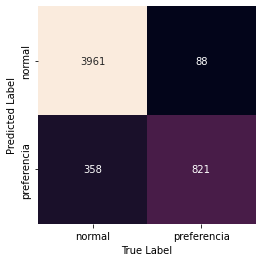

In [ ]:
#1. Criar um objeto de pipeline
pipeline_random_forest = Pipeline([
 
    ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, ngram_range = (1, 3))),     
     ('Random Forest', RandomForestClassifier(

         ))         
])

#2. Ajuste(fit) com X_train e y_train
pipeline_random_forest.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_rf = pipeline_random_forest.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_rf))

# Imprime a matriz de confusão 
mat = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      4319
           1       0.69      0.91      0.79       909

    accuracy                           0.91      5228
   macro avg       0.84      0.91      0.87      5228
weighted avg       0.93      0.91      0.92      5228



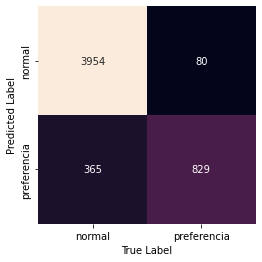

In [ ]:
#1. Criar um objeto de pipeline
pipeline_random_forest = Pipeline([
 
    ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, ngram_range = (1, 3))),     
     ('Random Forest', RandomForestClassifier(n_estimators=100, min_samples_leaf=2, 
                                              random_state=0, n_jobs=-1))         
])

#2. Ajuste(fit) com X_train e y_train
pipeline_random_forest.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_rf = pipeline_random_forest.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_rf))

# Imprime a matriz de confusão 
mat = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

### **Tentativa 3**: SVM

Usando o módulo pipeline sklearn foi criado um pipeline para classificar as petições.

Foi usado TF-IDF para pré-processar o texto.

Foi usado Unigram, Bigrams, Trigrams.

Foi usado **SVM** como classificador.


              precision    recall  f1-score   support

           0       0.98      0.90      0.94      4319
           1       0.66      0.89      0.76       909

    accuracy                           0.90      5228
   macro avg       0.82      0.90      0.85      5228
weighted avg       0.92      0.90      0.91      5228



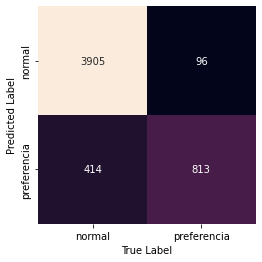

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
#1. Criar um objeto de pipeline
pipeline_svc = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, min_df=2, ngram_range = (1, 3))), 
    #  ('fs', SelectKBest(score_func=mutual_info_classif)),       
     ('SVC', SVC(kernel = 'linear', random_state=0))         
])

# pipeline_svc.set_params(fs__k=650)

#2. Ajuste(fit) com X_train e y_train
pipeline_svc.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_svm = pipeline_svc.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_svm))

# Imprime a matriz de confusão  
mat = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      4319
           1       0.70      0.90      0.79       909

    accuracy                           0.92      5228
   macro avg       0.84      0.91      0.87      5228
weighted avg       0.93      0.92      0.92      5228



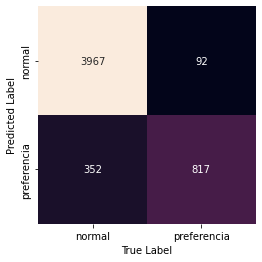

In [ ]:

#1. Criar um objeto de pipeline
pipeline_svc = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, ngram_range = (1, 3))), 
    #  ('fs', SelectKBest(score_func=mutual_info_classif)),       
     ('SVC', SVC(
         kernel = 'poly',
         degree=5,
         C=5, 
         random_state=0
         ))         
])

# pipeline_svc.set_params(fs__k=1000)

#2. Ajuste(fit) com X_train e y_train
pipeline_svc.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_svm = pipeline_svc.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_svm))

# Imprime a matriz de confusão  
mat = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

### **Tentativa 3**: ExtraTreesClassifier

Usando o módulo pipeline sklearn foi criado um pipeline para classificar as petições.

Foi usado TF-IDF para pré-processar o texto.

Foi usado Unigram, Bigrams, Trigrams.

Foi usado **SVM** como classificador.


              precision    recall  f1-score   support

           0       0.98      0.92      0.95      4319
           1       0.70      0.89      0.78       909

    accuracy                           0.91      5228
   macro avg       0.84      0.91      0.87      5228
weighted avg       0.93      0.91      0.92      5228



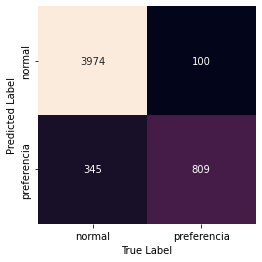

In [ ]:
#1. Criar um objeto de pipeline
pipeline_svc = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, ngram_range = (1, 3))), 
    #  ('fs', SelectKBest(score_func=mutual_info_classif)),       
     ('ExtraTreesClassifier', ExtraTreesClassifier())         
])

# pipeline_svc.set_params(fs__k=1000)

#2. Ajuste(fit) com X_train e y_train
pipeline_svc.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_svm = pipeline_svc.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_svm))

# Imprime a matriz de confusão  
mat = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      4319
           1       0.70      0.89      0.79       909

    accuracy                           0.92      5228
   macro avg       0.84      0.91      0.87      5228
weighted avg       0.93      0.92      0.92      5228



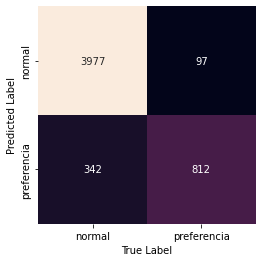

In [ ]:
#1. Criar um objeto de pipeline
pipeline_svc = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, ngram_range = (1, 3))), 
    #  ('fs', SelectKBest(score_func=mutual_info_classif)),       
     ('ExtraTreesClassifier', ExtraTreesClassifier(
                  n_estimators=300, 
        #  min_samples_leaf=2, 
         random_state=0, 
         n_jobs=-1
     ))         
])

# pipeline_svc.set_params(fs__k=1000)

#2. Ajuste(fit) com X_train e y_train
pipeline_svc.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_svm = pipeline_svc.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_svm))

# Imprime a matriz de confusão  
mat = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

### **Tentativa 4**: XGBoost

Usando o módulo pipeline sklearn foi criado um pipeline para classificar as petições.

Foi usado TF-IDF para pré-processar o texto.

Foi usado Unigram, Bigrams, Trigrams.

Foi usado **XGBoost** como classificador.


              precision    recall  f1-score   support

           0       0.98      0.92      0.95      4319
           1       0.70      0.92      0.80       909

    accuracy                           0.92      5228
   macro avg       0.84      0.92      0.87      5228
weighted avg       0.93      0.92      0.92      5228



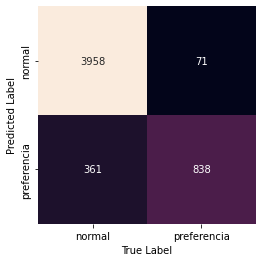

In [ ]:
#1. Criar um objeto de pipeline
pipeline_svc = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, ngram_range = (1, 3))),        
     ('XGBClassifier', XGBClassifier())         
])


#2. Ajuste(fit) com X_train e y_train
pipeline_svc.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_svm = pipeline_svc.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_svm))

# Imprime a matriz de confusão  
mat = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

***
## **Rotulando o processo em "Preferencial" ou "Urgente"** <img src="https://cdn-icons-png.flaticon.com/512/4229/4229803.png" width="3%">
***

<p>Na etapa atual da análise, usaremos a feature "Preferência Legal" para
classificar as petições iniciais em preferenciais e urgentes. Essa feature nos informa quais preferências legais estão anexadas a cada processo e, como descobrimos na análise exploratória dos dados, alguns processos possuem mais de uma preferência legal, e na base de dados estão separadas por ";".</p>

<p>Para essa etapa, decidimos excluir os processos normais, uma vez que não são
relevantes para a nossa análise. Nosso objetivo agora é focar nos processos
preferenciais e urgentes. Para determinar quais preferências legais se encaixam em processos que precisam de urgência na tramitação, foi conversado com servidores da Justiça Federal do Rio Grande do Norte. A partir dessa conversa, descobriu-se que apenas as preferências legais "Doença Terminal", "Preso/Acolhido/Internado" e "Réu Preso" são consideradas processos urgentes. </p>

<p>Para lidar com essa informação, criamos uma nova feature chamada
"preferencia_urgencia". Através de um mapeamento com Python, e utilizando
expressões regulares para identificar os termos de interesse, podemos identificar a existência dessas três preferências legais dentro do campo contendo as informações e classificar o processo como preferencial ou urgente, conforme a presença dessas preferências.
</p>

In [20]:
# dados.head()
df_modificado = dados.copy()
df_modificado['numero_processo'] = df_modificado['numero_processo'].str[:10] + '*' * 14 + df_modificado['numero_processo'].str[-4:]
df_modificado.head()

,numero_processo,conteudo_peticao,Flag Preferência Legal,Preferência Legal,text_clean
0,0800020-03**************8401,EXCELENTÍSSIMO (A) SENHOR (A) DOUTOR (A) JUIZ ...,0,None,íza var judici mossoró est rio grand nort coub...
1,0800019-94**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,0,None,direit edson mágn fre nóbreg brasil solt oab s...
2,0800019-91**************8401,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DE U...,0,None,var feder mossoró est rio grand nort luan pris...
3,0800019-77**************8404,EXCELENTÍSSIMO SENHOR JUIZ DA 12ª VARA FEDERAL...,0,None,pau ferr est rio grand nort execuç fiscal tota...
4,0800019-78**************8402,ADVOCACIA-GERAL DA UNIÃO\nPROCURADORIA-GERAL F...,0,None,advocac procurad equip nacion cobranç set ajui...


In [21]:
dados['Preferência Legal'].unique()

array([None, 'Doença Terminal;Idoso(a)', 'Idoso(a)', 'Doença Terminal',
       'Grande Devedor', 'Pessoa com Deficiência',
       'Idoso(a) maior de 80 anos',
       'Doença Terminal;Pessoa com Deficiência',
       'Doença Terminal;Idoso(a) maior de 80 anos',
       'Doença Terminal;Idoso(a);Pessoa com Deficiência',
       'Grande Devedor;Idoso(a)', 'Idoso(a);Pessoa com Deficiência',
       'Idoso(a);Idoso(a) maior de 80 anos'], dtype=object)

In [22]:
dados_parte2 = dados.copy()

In [23]:
# dados_parte2
df_modificado = dados_parte2.copy()
df_modificado['numero_processo'] = df_modificado['numero_processo'].str[:10] + '*' * 14 + df_modificado['numero_processo'].str[-4:]
df_modificado

,numero_processo,conteudo_peticao,Flag Preferência Legal,Preferência Legal,text_clean
0,0800020-03**************8401,EXCELENTÍSSIMO (A) SENHOR (A) DOUTOR (A) JUIZ ...,0,None,íza var judici mossoró est rio grand nort coub...
1,0800019-94**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,0,None,direit edson mágn fre nóbreg brasil solt oab s...
2,0800019-91**************8401,EXCELENTÍSSIMO SENHOR DOUTOR JUIZ FEDERAL DE U...,0,None,var feder mossoró est rio grand nort luan pris...
3,0800019-77**************8404,EXCELENTÍSSIMO SENHOR JUIZ DA 12ª VARA FEDERAL...,0,None,pau ferr est rio grand nort execuç fiscal tota...
4,0800019-78**************8402,ADVOCACIA-GERAL DA UNIÃO\nPROCURADORIA-GERAL F...,0,None,advocac procurad equip nacion cobranç set ajui...
...,...,...,...,...,...
26131,0813206-96**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,0,None,est rio grand nort coub legal ord advog brasil...
26132,0813204-29**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,0,None,est rio grand nort coub legal ord advog brasil...
26133,0813201-74**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,0,None,est rio grand nort coub legal ord advog brasil...
26134,0813203-44**************8400,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,0,None,est rio grand nort coub legal ord advog brasil...


In [26]:
def preferencia_urgencia(preferencia_legal):
  if preferencia_legal == None:
    return 'normal'
  else:
    regex_urgencia = r"(Doença Terminal|Preso)"
    urgencia = re.search(regex_urgencia, str(preferencia_legal)) 

    if urgencia is None:
      return 'preferencial'  
    else:
      return 'urgente'

dados_parte2['preferencia_urgencia'] = dados_parte2['Preferência Legal'].apply(preferencia_urgencia)

In [27]:
dados_parte2['preferencia_urgencia'].value_counts()

normal          21591
preferencial     3573
urgente           972
Name: preferencia_urgencia, dtype: int64

In [28]:
# Excluindo processos "normais" da analise
dados_parte2 = dados_parte2.drop(dados_parte2[dados_parte2['preferencia_urgencia'] == 'normal'].index)

In [29]:
# dados_parte2
df_modificado = dados_parte2.copy()
df_modificado['numero_processo'] = df_modificado['numero_processo'].str[:10] + '*' * 14 + df_modificado['numero_processo'].str[-4:]
df_modificado

,numero_processo,conteudo_peticao,Flag Preferência Legal,Preferência Legal,text_clean,preferencia_urgencia
5,0800019-60**************8400,Excelentíssimo(a) Senhor(a) Doutor(a) Juiz(a) ...,1,Doença Terminal;Idoso(a),var est rio grand nort coub legal august benev...,urgente
7,0800019-65**************8400,"PROCESSO:\nAUTUAÇÃO: [FENO JOSEPH FURMANEK, MA...",1,Idoso(a),autu fen joseph furmanek manoel sant nogu net ...,preferencial
8,0800019-54**************8402,Excelentíssimo (a) Senhor (a) Juiz (Juíza) Fed...,1,Idoso(a),juíz rio grand nort ref autor sindicat trabalh...,preferencial
22,0800018-93**************8402,EXCELENTÍSSIMO(A) SENHOR(A) DOUTOR(A) JUIZ(A) ...,1,Doença Terminal,rio grand nort promov gil anizi med promov esp...,urgente
25,0800018-75**************8400,EXCELENTÍSSIMO SENHOR JUIZ FEDERAL DE UMA DAS ...,1,Doença Terminal,var est rio grand nort urg saúd gratuit iarali...,urgente
...,...,...,...,...,...,...
26034,0812580-77**************8400,Excelentíssimo Senhor Juiz Federal de um dos J...,1,Idoso(a),juiz espec feder fazend comarc natal legal pri...,preferencial
26038,0812575-55**************8400,...,1,Idoso(a),advocac assess juríd mar lourd alban oab veníc...,preferencial
26050,0813384-45**************8400,EXCELENTÍSSIMO (A) SENHOR (A) DOUTOR (A) JUIZ ...,1,Idoso(a) maior de 80 anos,direit uma var cível feder comarc natal prior ...,preferencial
26051,0813381-90**************8400,EXCELENTÍSSIMO(A) JUIZ(ÍZA) DE DIREITO DE UMA ...,1,Idoso(a),íza direit var feder rio grand nort coub legal...,preferencial


In [30]:
counts = dados_parte2['preferencia_urgencia'].value_counts().reset_index()
counts.columns = ['Categoria', 'quantidade']
# counts['Categoria'].replace(0, 'Normal', inplace=True)
# counts['Categoria'].replace(1, 'Preferencial', inplace=True)
colors = {
    'preferencial': 'Orange',
    'urgente': 'Red'
}

fig = px.bar(counts, x='Categoria', y='quantidade', color='Categoria', 
             color_discrete_map=colors, text='quantidade', width=600
             )

fig.update_traces(textposition='outside')
fig.show()

***
## **Treinamento e Predição[parte 2]** <img src="https://cdn-icons-png.flaticon.com/512/3273/3273713.png" width="3%">
 Triagem de processos "Preferenciais" e "Urgentes"
***

In [ ]:
# dados_parte2

flag = {'preferencial': 0, 'urgente': 1}


dados_parte2['preferencia_urgencia'] = dados_parte2['preferencia_urgencia'].map(flag)


In [ ]:
dados_parte2['preferencia_urgencia'].value_counts()

0    3573
1     972
Name: preferencia_urgencia, dtype: int64

In [ ]:
X = dados_parte2.text_clean
y= dados_parte2['preferencia_urgencia']

In [ ]:
# Separa os dados de treino e de teste


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.20, # 20% de dados de teste
    random_state=42,
    stratify=dados_parte2['preferencia_urgencia']
)

In [ ]:
'''
o scikit-learn espera duas coisas nesta etapa:

-Que a variável X seja sempre um np.array com duas dimensões
-Que a variável y seja sempre um np.array com uma dimensão

 Foi preciso mudar a dimensão do array para atender a condição acima, por isso foi usado o .reshape(-1,1).
'''
X_train = X_train.values.reshape(-1,1)

In [ ]:
# Definindo o UnderSamplere e aplicando para o x e o y de treino
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

print(y_res.value_counts())

0    778
1    778
Name: preferencia_urgencia, dtype: int64


In [ ]:
y_test.value_counts()

0    715
1    194
Name: preferencia_urgencia, dtype: int64

In [ ]:
dicionario_preferencia_peticoes = {'preferencial': 0, 'urgente': 1}
dicionario_preferencia_peticoes

{'preferencial': 0, 'urgente': 1}

### **Tentativa 1**: Random Forest

Usando o módulo pipeline sklearn foi criado um pipeline para classificar as petições.

Foi usado TF-IDF para pré-processar o texto.

Foi usado Unigram, Bigrams, Trigrams.

Foi usado **Random Forest** como classificador.


              precision    recall  f1-score   support

           0       0.97      0.94      0.96       715
           1       0.81      0.91      0.86       194

    accuracy                           0.94       909
   macro avg       0.89      0.93      0.91       909
weighted avg       0.94      0.94      0.94       909



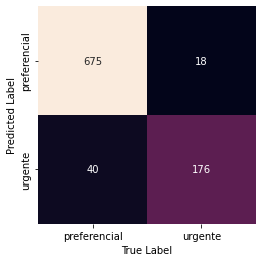

In [ ]:
#1. Criar um objeto de pipeline
pipeline_random_forest = Pipeline([
 
    ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, ngram_range = (1, 3))),     
     ('Random Forest', RandomForestClassifier())         
])

#2. Ajuste(fit) com X_train e y_train
pipeline_random_forest.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_rf = pipeline_random_forest.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_rf))

# Imprime a matriz de confusão 
mat = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       715
           1       0.83      0.90      0.86       194

    accuracy                           0.94       909
   macro avg       0.90      0.92      0.91       909
weighted avg       0.94      0.94      0.94       909



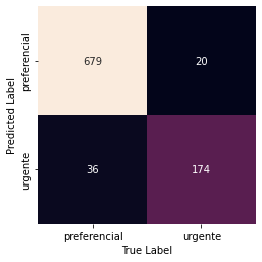

In [ ]:
#1. Criar um objeto de pipeline
pipeline_random_forest = Pipeline([
 
    ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, ngram_range = (1, 3))),     
     ('Random Forest', RandomForestClassifier(
         random_state=0, n_jobs=-1
     ))         
])

#2. Ajuste(fit) com X_train e y_train
pipeline_random_forest.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_rf = pipeline_random_forest.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_rf))

# Imprime a matriz de confusão 
mat = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

### **Tentativa 2**: SVM

Usando o módulo pipeline sklearn foi criado um pipeline para classificar as petições.

Foi usado TF-IDF para pré-processar o texto.

Foi usado Unigram, Bigrams, Trigrams.

Foi usado **SVM** como classificador.


              precision    recall  f1-score   support

           0       0.97      0.94      0.96       715
           1       0.81      0.90      0.85       194

    accuracy                           0.93       909
   macro avg       0.89      0.92      0.91       909
weighted avg       0.94      0.93      0.94       909



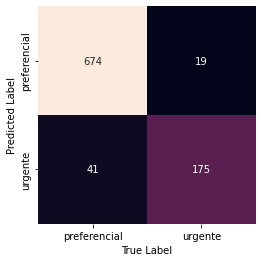

In [ ]:

#1. Criar um objeto de pipeline
pipeline_svc = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, min_df=4,ngram_range = (1, 3))), 
    #  ('fs', SelectKBest(score_func=mutual_info_classif)),       
     ('SVC', SVC(
         random_state=0
         ))         
])

# pipeline_svc.set_params(fs__k=1000)

#2. Ajuste(fit) com X_train e y_train
pipeline_svc.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_svm = pipeline_svc.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_svm))

# Imprime a matriz de confusão  
mat = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.95      0.96       715
           1       0.83      0.91      0.87       194

    accuracy                           0.94       909
   macro avg       0.90      0.93      0.92       909
weighted avg       0.94      0.94      0.94       909



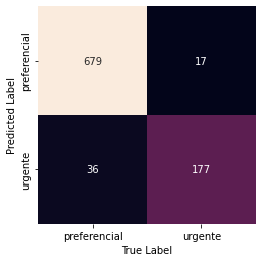

In [ ]:

#1. Criar um objeto de pipeline
pipeline_svc = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, ngram_range = (2, 2))), 
    #  ('fs', SelectKBest(score_func=mutual_info_classif)),       
     ('SVC', SVC(
         kernel = 'rbf', 
         C=5,
         random_state=0
         ))         
])

# pipeline_svc.set_params(fs__k=1000)

#2. Ajuste(fit) com X_train e y_train
pipeline_svc.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_svm = pipeline_svc.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_svm))

# Imprime a matriz de confusão  
mat = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

### **Tentativa 3**: ExtraTreesClassifier

Usando o módulo pipeline sklearn foi criado um pipeline para classificar as petições.

Foi usado TF-IDF para pré-processar o texto.

Foi usado Unigram, Bigrams, Trigrams.

Foi usado **ExtraTreesClassifier** como classificador.


              precision    recall  f1-score   support

           0       0.97      0.95      0.96       715
           1       0.84      0.90      0.87       194

    accuracy                           0.94       909
   macro avg       0.90      0.92      0.91       909
weighted avg       0.94      0.94      0.94       909



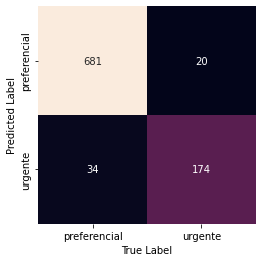

In [ ]:
#1. Criar um objeto de pipeline
pipeline_svc = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, min_df=4,ngram_range = (1, 3))), 
    #  ('fs', SelectKBest(score_func=mutual_info_classif)),       
     ('ExtraTreesClassifier', ExtraTreesClassifier(

     ))         
])

# pipeline_svc.set_params(fs__k=1000)

#2. Ajuste(fit) com X_train e y_train
pipeline_svc.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_svm = pipeline_svc.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_svm))

# Imprime a matriz de confusão  
mat = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       715
           1       0.83      0.90      0.87       194

    accuracy                           0.94       909
   macro avg       0.90      0.93      0.91       909
weighted avg       0.94      0.94      0.94       909



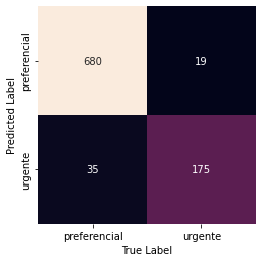

In [ ]:
#1. Criar um objeto de pipeline
pipeline_svc = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, min_df=4,ngram_range = (1, 3))), 
    #  ('fs', SelectKBest(score_func=mutual_info_classif)),       
     ('ExtraTreesClassifier', ExtraTreesClassifier(
                  n_estimators=400, 
        #  min_samples_leaf=2, 
         random_state=0, 
         n_jobs=-1
     ))         
])

# pipeline_svc.set_params(fs__k=1000)

#2. Ajuste(fit) com X_train e y_train
pipeline_svc.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_svm = pipeline_svc.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_svm))

# Imprime a matriz de confusão  
mat = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()

### **Tentativa 4**: XGBoost

Usando o módulo pipeline sklearn foi criado um pipeline para classificar as petições.

Foi usado TF-IDF para pré-processar o texto.

Foi usado Unigram, Bigrams, Trigrams.

Foi usado **XGBoost** como classificador.


              precision    recall  f1-score   support

           0       0.98      0.95      0.96       715
           1       0.82      0.92      0.87       194

    accuracy                           0.94       909
   macro avg       0.90      0.93      0.91       909
weighted avg       0.94      0.94      0.94       909



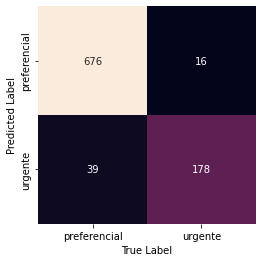

In [ ]:
#1. Criar um objeto de pipeline
pipeline_svc = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer(max_features=2000, ngram_range = (1, 3))),        
     ('XGBClassifier', XGBClassifier())         
])


#2. Ajuste(fit) com X_train e y_train
pipeline_svc.fit(X_res.flatten(), y_res)


#3. Obter previsões para X_test e armazenar em y_pred
y_pred_svm = pipeline_svc.predict(X_test)

# imprimir relatório 
print(classification_report(y_test, y_pred_svm))

# Imprime a matriz de confusão  
mat = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,
            xticklabels=list(dicionario_preferencia_peticoes.keys()),yticklabels=list(dicionario_preferencia_peticoes.keys()))
plt.xlabel('True Label')
plt.ylabel("Predicted Label")
plt.show()